# Capstone Project - North Shore Oahu Wave forecast 

## 1.0 Importing data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from time import time 

In [2]:
df = pd.read_csv(r"C:\Users\edwar\OneDrive\Documents\Digital Futures\Capstone Project\oahufull.csv")
df.head()

,date,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,wdir,nsd,ssd
0,01/01/1990,5,2,1,1,6,6,3,999,999
1,02/01/1990,4,2,1,1,5,5,3,999,999
2,03/01/1990,8,4,2,2,5,5,3,999,999
3,04/01/1990,5,4,1,2,5,5,3,999,999
4,05/01/1990,6,4,1,2,5,6,3,999,999


## 2.0 cleaning data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             11304 non-null  object
 1   northshore wh    11304 non-null  int64 
 2   west side wh     11304 non-null  int64 
 3   southshore wh    11304 non-null  int64 
 4   diamond head wh  11304 non-null  int64 
 5   east side wh     11304 non-null  int64 
 6   wspd             11304 non-null  int64 
 7   wdir             11304 non-null  int64 
 8   nsd              11304 non-null  int64 
 9   ssd              11304 non-null  object
dtypes: int64(8), object(2)
memory usage: 883.3+ KB


#### 2.1 Converting date into date into datetime object

In [4]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)  

#### 2.2 Replace data set assigned nulls (999) with NaN

In [5]:
df.replace(999, np.NaN, inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             11304 non-null  datetime64[ns]
 1   northshore wh    11304 non-null  int64         
 2   west side wh     11304 non-null  int64         
 3   southshore wh    11304 non-null  int64         
 4   diamond head wh  11304 non-null  int64         
 5   east side wh     11304 non-null  int64         
 6   wspd             11304 non-null  int64         
 7   wdir             11185 non-null  float64       
 8   nsd              7464 non-null   float64       
 9   ssd              11304 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 883.3+ KB


#### 2.3 Counting nulls

In [7]:
df.isnull().sum()

date                  0
northshore wh         0
west side wh          0
southshore wh         0
diamond head wh       0
east side wh          0
wspd                  0
wdir                119
nsd                3840
ssd                   0
dtype: int64

In [8]:
## Dropping ssd column, useless and too many 999 values
df = df.drop(['ssd'], axis = 1)

In [9]:
df.shape

(11304, 9)

In [10]:
df.head()

,date,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,wdir,nsd
0,1990-01-01,5,2,1,1,6,6,3.0,NaN
1,1990-01-02,4,2,1,1,5,5,3.0,NaN
2,1990-01-03,8,4,2,2,5,5,3.0,NaN
3,1990-01-04,5,4,1,2,5,5,3.0,NaN
4,1990-01-05,6,4,1,2,5,6,3.0,NaN


#### 2.4 Handeling nsd nulls

In [11]:
nodate = df.drop('date', axis = 1).copy()  ## Creating a table with no date column to run in a classification model 
nodate

,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,wdir,nsd
0,5,2,1,1,6,6,3.0,NaN
1,4,2,1,1,5,5,3.0,NaN
2,8,4,2,2,5,5,3.0,NaN
3,5,4,1,2,5,5,3.0,NaN
4,6,4,1,2,5,6,3.0,NaN
...,...,...,...,...,...,...,...,...
11299,8,4,1,1,2,2,17.0,15.0
11300,12,7,1,1,2,3,4.0,16.0
11301,15,8,2,2,2,4,5.0,16.0
11302,6,3,2,2,2,2,17.0,16.0


In [12]:
nodate =  pd.get_dummies(nodate, columns = ['wdir'], prefix = 'wdir', drop_first = True, dtype = int)  ## Getting dummy columns for the wind direction
nodate

,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,nsd,wdir_2.0,wdir_3.0,wdir_4.0,...,wdir_9.0,wdir_10.0,wdir_11.0,wdir_12.0,wdir_13.0,wdir_14.0,wdir_15.0,wdir_16.0,wdir_17.0,wdir_18.0
0,5,2,1,1,6,6,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2,1,1,5,5,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8,4,2,2,5,5,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5,4,1,2,5,5,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6,4,1,2,5,6,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11299,8,4,1,1,2,2,15.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11300,12,7,1,1,2,3,16.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11301,15,8,2,2,2,4,16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11302,6,3,2,2,2,2,16.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
X_train = nodate[nodate['nsd'].notnull()].drop('nsd', axis = 1)  ## Test train splitting to model the nulls in the NSD column
X_train;

In [14]:
X_test = nodate[df['nsd'].isnull()].drop('nsd', axis = 1)
X_test;

In [15]:
y_train = nodate['nsd'][nodate['nsd'].notnull()]
y_train;

In [16]:
y_test = nodate['nsd'][nodate['nsd'].isnull()]
y_test;

In [17]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),  # The model
                    param_grid = {'max_depth': [3, 5, 7, 10], # how many levels will the tree have 
                                  'min_samples_split': [5, 10, 15, 20, 50, 100], #how many samples to make a split
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7], # how many samples to make a leaf 
                                  'max_features':[2,5]}, # How many parameters can I use 
                    cv = 10,  ## How many splits
                    refit = True,  ## Do we r3efit the data on each run?
                    verbose = 1,  ## How much to tell us
                    scoring = 'accuracy')  ## Which metric am I maximising

In [18]:
grid.fit(X_train, y_train)  ## Fitting gridsearch to my data

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


C:\Users\edwar\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10], 'max_features': [2, 5],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [5, 10, 15, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [19]:
grid.best_params_

{'max_depth': 7,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [20]:
grid.best_score_  ## Not great but okay to model my nulls

0.3744531297666089

In [27]:
dt = DecisionTreeClassifier(max_depth = 7,
                           max_features = 5,
                           min_samples_leaf = 2,
                           min_samples_split = 5)  ## Creating a decision tree with our chosen parameters 

In [28]:
model = dt.fit(X_train, y_train) ## fitting model to my data 

In [29]:
print(f'Score on training set: {dt.score(X_train, y_train)}') ## Accuracy of my model

Score on training set: 0.4032690246516613


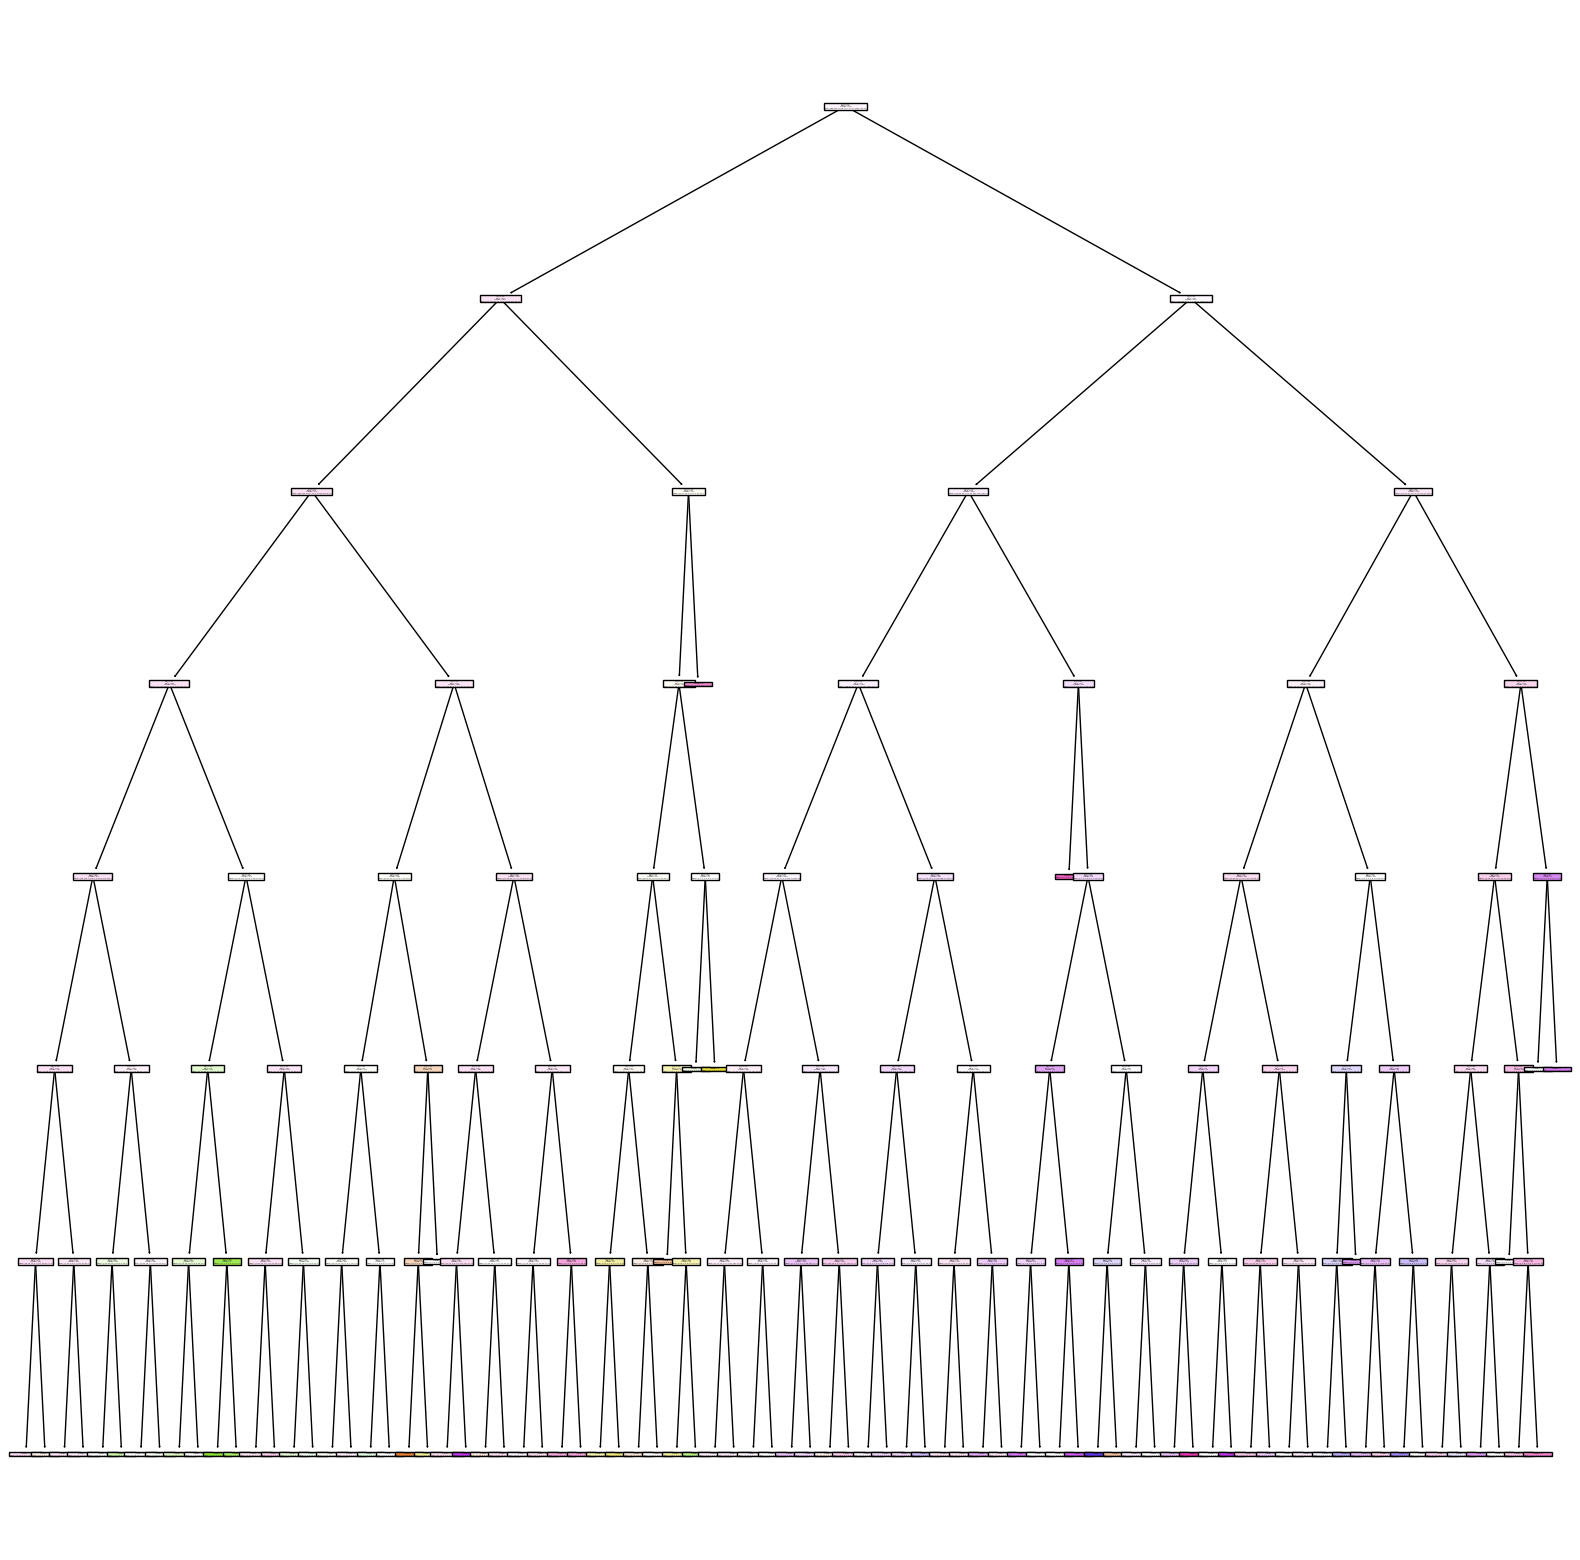

In [32]:
plt.figure(figsize=(20,20))
tree.plot_tree(dt, ##  decision tree classifier 
                   filled=True)  ## just for aesthetics 
plt.show()

In [35]:
y_predicted = dt.predict(X_test)  ## creating array of predicted nsd values

In [36]:
null_indices = df['nsd'].isnull()
null_indices

0         True
1         True
2         True
3         True
4         True
         ...  
11299    False
11300    False
11301    False
11302    False
11303    False
Name: nsd, Length: 11304, dtype: bool

In [40]:
df.loc[null_indices, 'nsd'] = y_predicted  ## mapping predicted values onto df

In [41]:
nodate.loc[null_indices, 'nsd'] = y_predicted  ## same for nodate

In [42]:
df.isnull().sum()  ## checking the nulls

date                 0
northshore wh        0
west side wh         0
southshore wh        0
diamond head wh      0
east side wh         0
wspd                 0
wdir               119
nsd                  0
dtype: int64

#### 2.5 Handling wind direction nulls - same process as before

In [43]:
nodate2 = df.drop('date', axis = 1).copy()
nodate2 = pd.get_dummies(nodate2, columns = ['nsd'], prefix = 'nsd', drop_first = True, dtype = int)  ## creating a new dataframe and making nsd dummies

In [50]:
X_train2 = nodate2[nodate2['wdir'].notnull()].drop('wdir', axis = 1)  ## Test train splitting ready to model the wdir nulls
X_train2;

In [45]:
X_test2 = nodate2[nodate2['wdir'].isnull()].drop('wdir', axis = 1)
X_test2;

In [46]:
y_train2 = nodate2['wdir'][nodate2['wdir'].notnull()]
y_train;

In [47]:
y_test2 = nodate2['wdir'][nodate2['wdir'].isnull()]
y_test2;

In [55]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),  # what is the model
                    param_grid = {'max_depth': [3, 5, 7, 10], # How deep is my tree
                                  'min_samples_split': [5, 10, 15, 20, 50, 100], #how many samples to make a split
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7], # how many samples to make a leaf 
                                  'max_features':[2,5]}, # How many parameters can I use 
                    cv = 10,  ## How many splits
                    refit = True,  ## Do we r3efit the data on each run?
                    verbose = 1,  ## How much to tell us
                    scoring = 'accuracy')  ## Which metric am I maximising

In [56]:
grid.fit(X_train, y_train)


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


C:\Users\edwar\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10], 'max_features': [2, 5],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [5, 10, 15, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [57]:
grid.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 50}

In [59]:
grid.best_score_  ## Again not great but okay for nulls

0.3788758250158812

In [60]:
dt2 = DecisionTreeClassifier(max_depth = 10,
                             max_features = 5,
                             min_samples_leaf = 3,
                             min_samples_split = 50)

In [61]:
dt2.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=3,
                       min_samples_split=50)

In [62]:
print(f'Score on training set: {dt.score(X_train, y_train)}')

Score on training set: 0.4032690246516613


In [63]:
y_predicted2 = dt2.predict(X_test2)

In [64]:
null_indices2 = df['wdir'].isnull()

In [68]:
df.loc[null_indices2, 'wdir'] = y_predicted2 ## Mapping predicted values onto df

In [67]:
df.isnull().sum() ## checking nulls again

date               0
northshore wh      0
west side wh       0
southshore wh      0
diamond head wh    0
east side wh       0
wspd               0
wdir               0
nsd                0
dtype: int64

#### 2.6 Checking for duplicates 

In [69]:
duplicates = df[df.duplicated()]

In [70]:
duplicates

,date,northshore wh,west side wh,southshore wh,diamond head wh,east side wh,wspd,wdir,nsd


In [73]:
df.info()  ## final scan to see if data is clean 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             11304 non-null  datetime64[ns]
 1   northshore wh    11304 non-null  int64         
 2   west side wh     11304 non-null  int64         
 3   southshore wh    11304 non-null  int64         
 4   diamond head wh  11304 non-null  int64         
 5   east side wh     11304 non-null  int64         
 6   wspd             11304 non-null  int64         
 7   wdir             11304 non-null  float64       
 8   nsd              11304 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 794.9 KB


In [74]:
df.to_csv('oahufullandclean.csv', index=False)  ## exporting DF to csv for later use 

## 3.0 EDA

In [75]:
corr = df.corr()

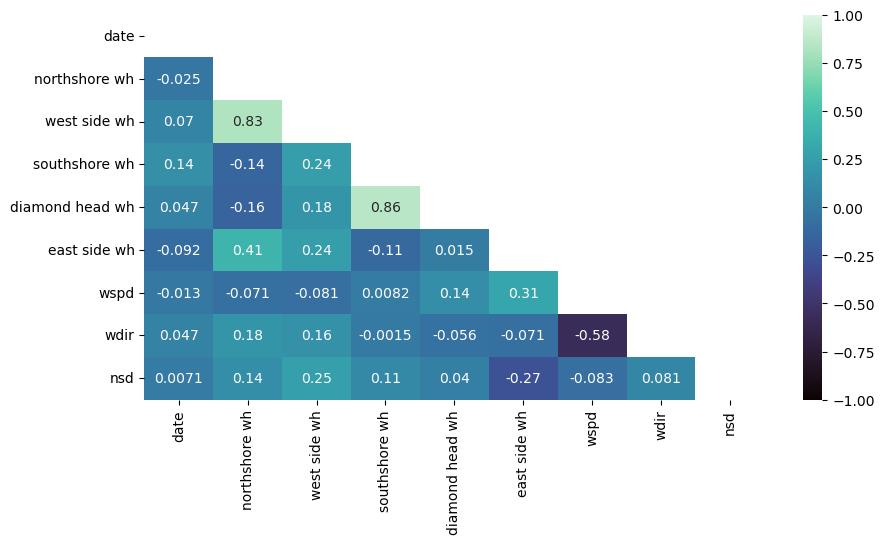

In [76]:
# Correlation heatmap 

plt.figure(figsize = (10,5))
sns.heatmap(data = corr,
            cmap = 'mako',
           annot = True,
           mask = np.triu(corr),
           vmin = -1,
           vmax = 1)
plt.show()

<Axes: >

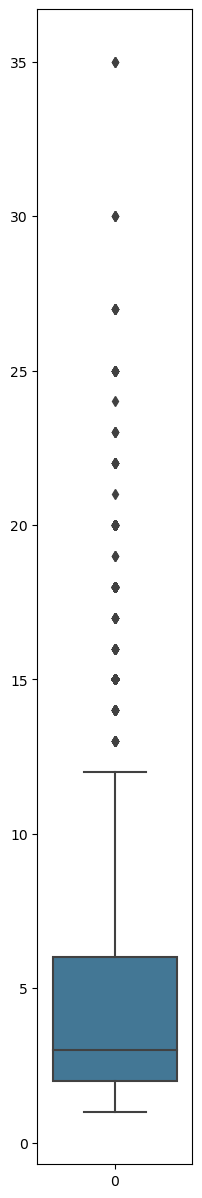

In [78]:
## Boxplot looking at outliers in the northshore waveheight column 

plt.figure(figsize = (2,15))
sns.boxplot(df['northshore wh'],
           palette = 'mako')


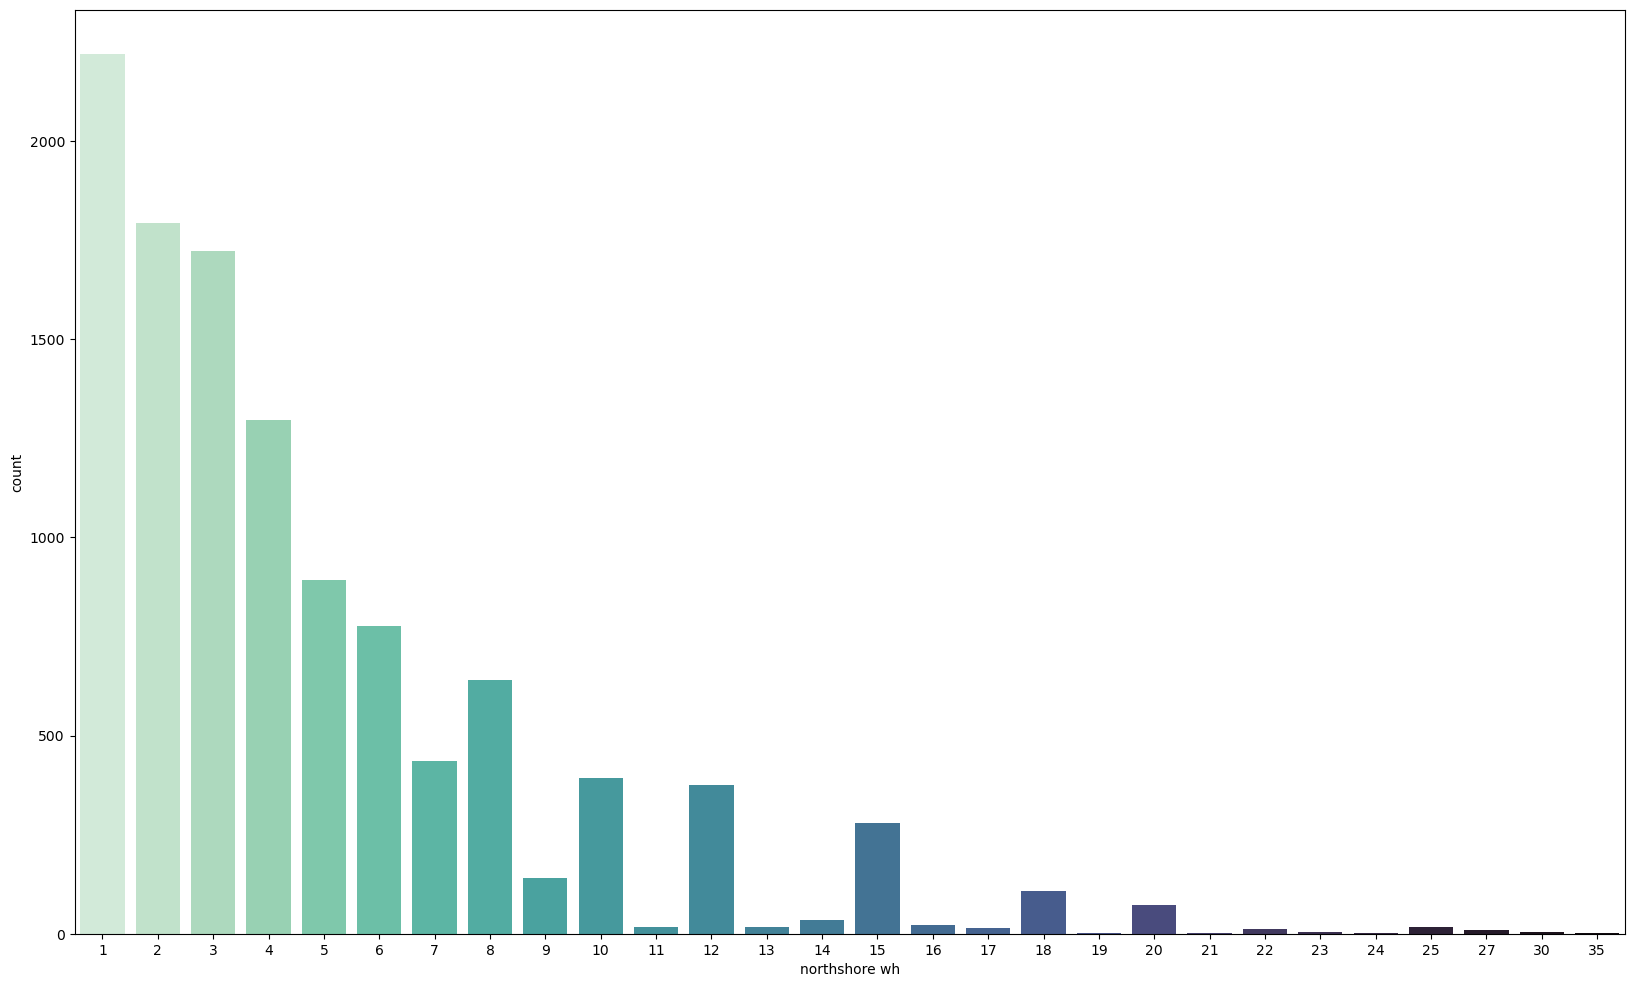

In [79]:
# Bar chart of Northshore wave heights
plt.figure(figsize = (20,12))
sns.countplot(df, x = 'northshore wh',
             palette = 'mako_r')
plt.savefig("image.png")
plt.show()


C:\Users\edwar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


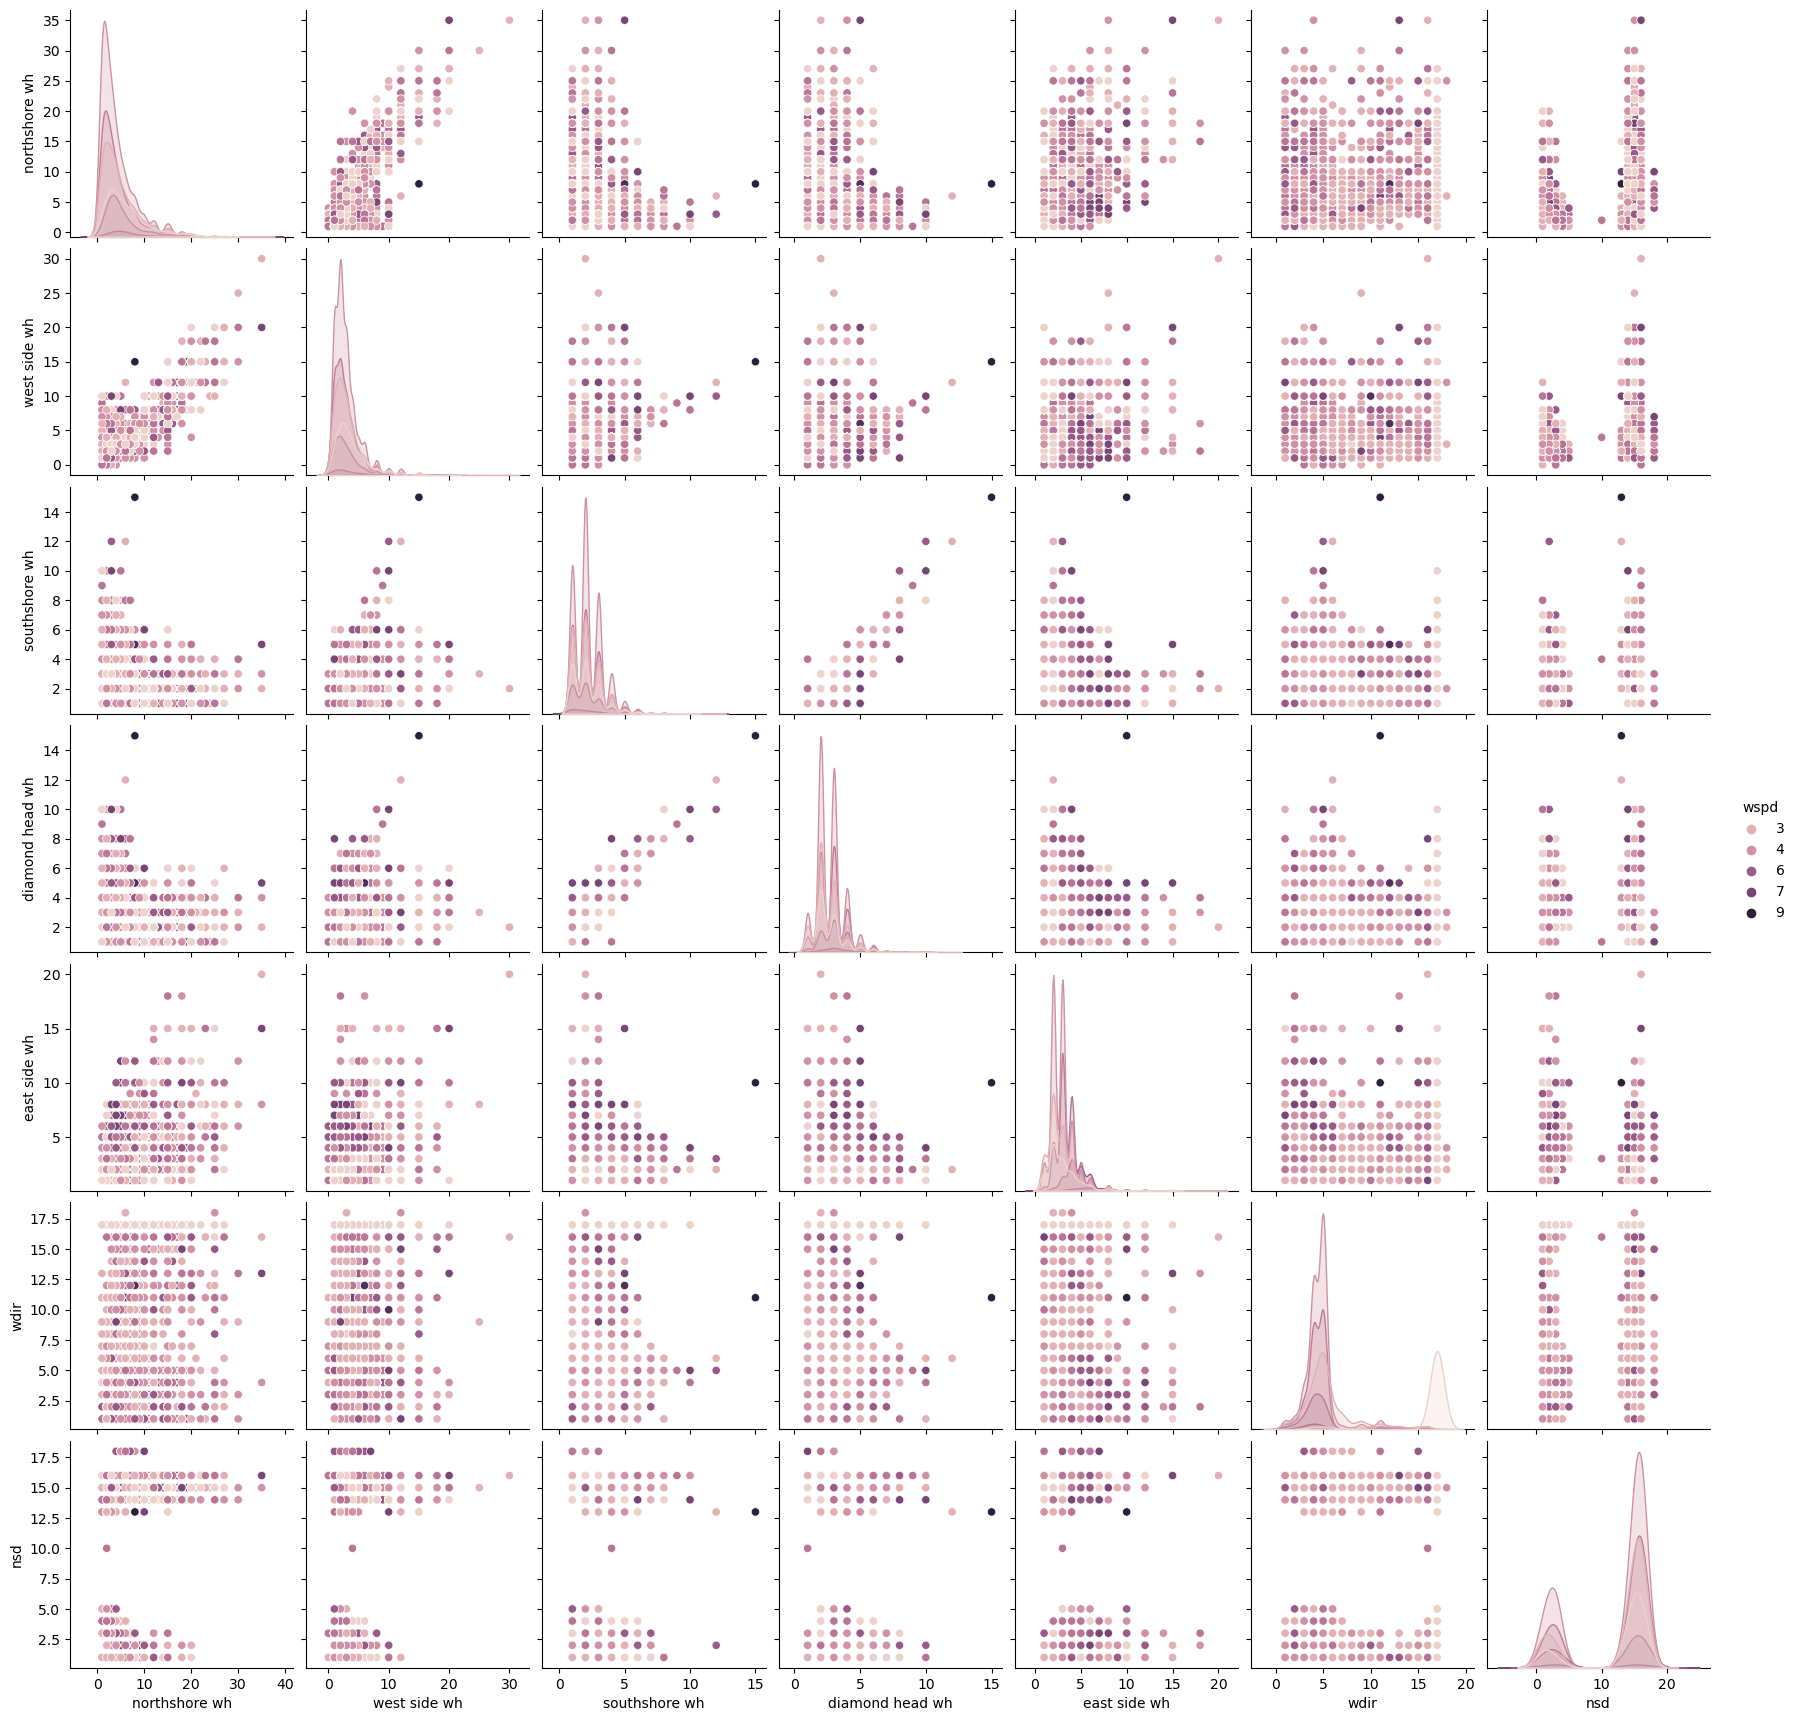

In [80]:
sns.pairplot(df,
            hue = 'wspd')
plt.show();

<Axes: xlabel='northshore wh', ylabel='west side wh'>

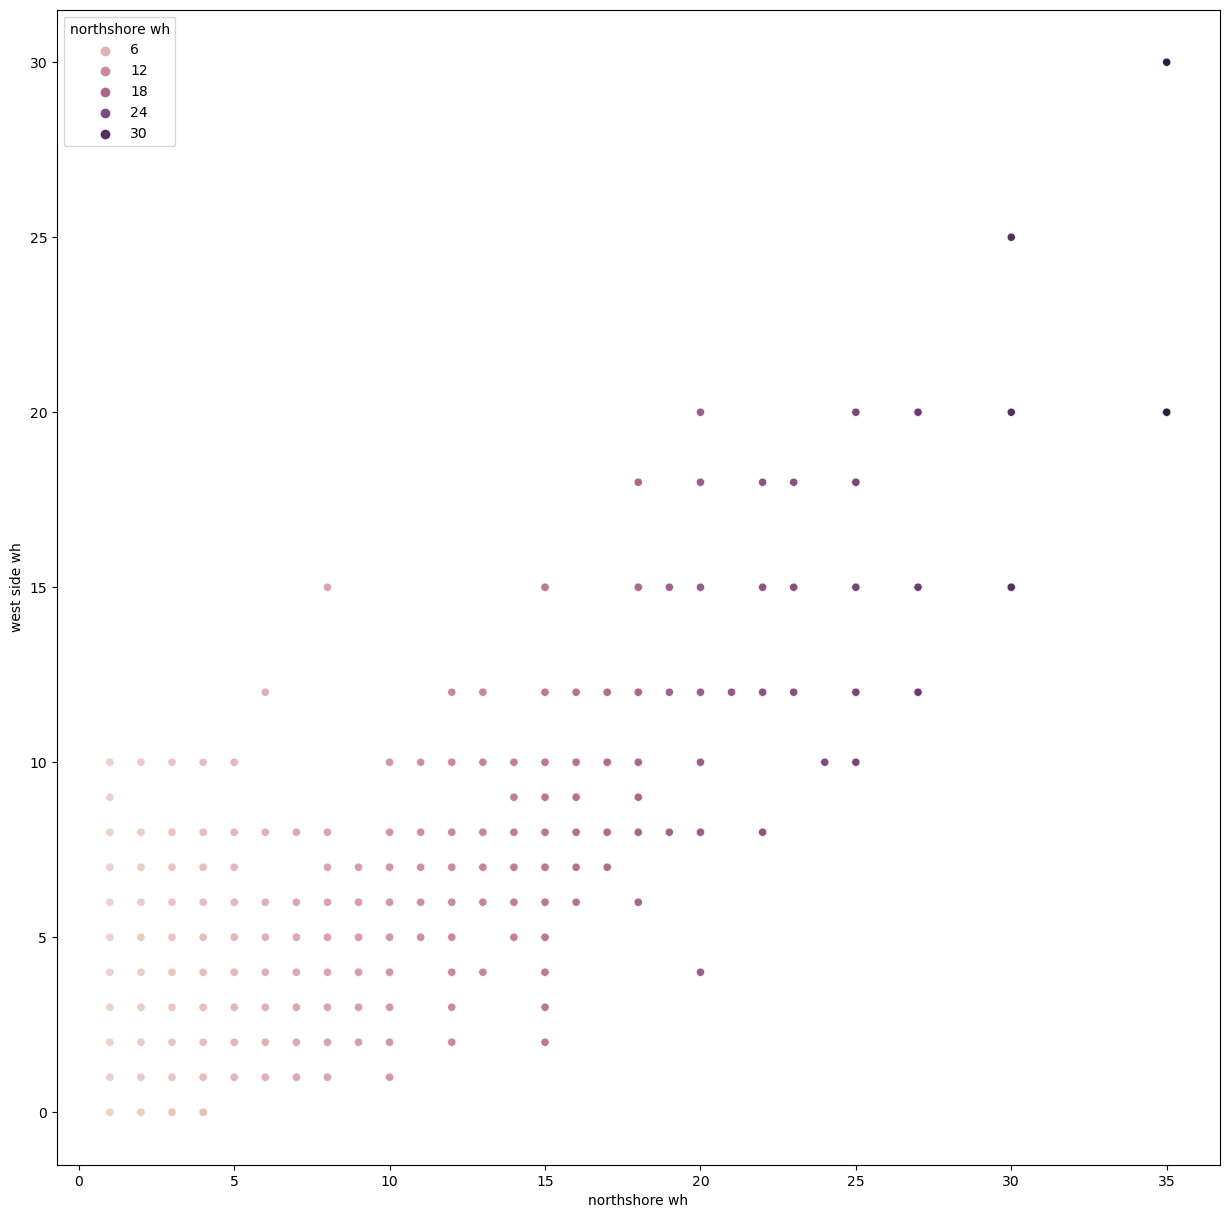

In [82]:
## scatterplot looking at relationship between waveheughts on the westside and north shore
plt.figure(figsize = (15,15))
sns.scatterplot(x="northshore wh", y="west side wh",
             data=df,
               hue = 'northshore wh')